The estimated value of the contract is: $-2720.00


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
<ipython-input-3-8a22abbdcc45>:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return forecast[days_diff]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No

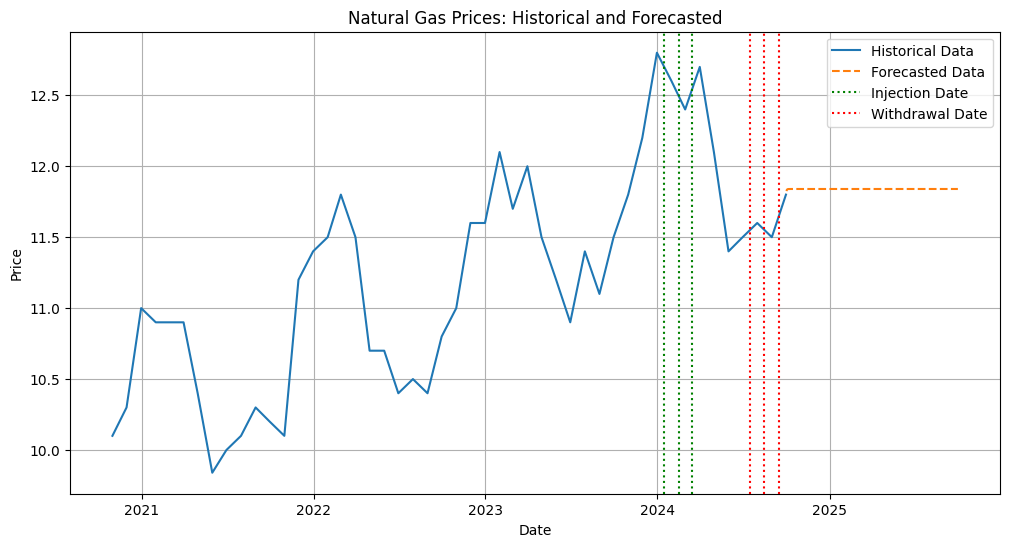

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
import io

# The data as a string (replace this with file reading if you have an actual file)
data_string = """Dates,Prices
10/31/20,1.01E+01
11/30/20,1.03E+01
12/31/20,1.10E+01
1/31/21,1.09E+01
2/28/21,1.09E+01
3/31/21,1.09E+01
4/30/21,1.04E+01
5/31/21,9.84E+00
6/30/21,1.00E+01
7/31/21,1.01E+01
8/31/21,1.03E+01
9/30/21,1.02E+01
10/31/21,1.01E+01
11/30/21,1.12E+01
12/31/21,1.14E+01
1/31/22,1.15E+01
2/28/22,1.18E+01
3/31/22,1.15E+01
4/30/22,1.07E+01
5/31/22,1.07E+01
6/30/22,1.04E+01
7/31/22,1.05E+01
8/31/22,1.04E+01
9/30/22,1.08E+01
10/31/22,1.10E+01
11/30/22,1.16E+01
12/31/22,1.16E+01
1/31/23,1.21E+01
2/28/23,1.17E+01
3/31/23,1.20E+01
4/30/23,1.15E+01
5/31/23,1.12E+01
6/30/23,1.09E+01
7/31/23,1.14E+01
8/31/23,1.11E+01
9/30/23,1.15E+01
10/31/23,1.18E+01
11/30/23,1.22E+01
12/31/23,1.28E+01
1/31/24,1.26E+01
2/29/24,1.24E+01
3/31/24,1.27E+01
4/30/24,1.21E+01
5/31/24,1.14E+01
6/30/24,1.15E+01
7/31/24,1.16E+01
8/31/24,1.15E+01
9/30/24,1.18E+01"""

# Load and preprocess the data
data = pd.read_csv(io.StringIO(data_string))
data['Dates'] = pd.to_datetime(data['Dates'], format='%m/%d/%y')
data['Prices'] = pd.to_numeric(data['Prices'], errors='coerce')
data.set_index('Dates', inplace=True)

# Function to estimate price for a given date
def estimate_price(date):
    if isinstance(date, str):
        date = pd.to_datetime(date)

    if date < data.index.min() or date > data.index.max() + pd.Timedelta(days=365):
        return None

    if date <= data.index.max():
        return data.loc[date:].iloc[0]['Prices']

    # For future dates, use ARIMA forecast
    model = ARIMA(data['Prices'], order=(1,1,1))
    results = model.fit()
    forecast = results.forecast(steps=365)
    forecast_date = data.index.max() + pd.Timedelta(days=1)
    days_diff = (date - forecast_date).days
    return forecast[days_diff]

# Function to price the gas storage contract
def price_storage_contract(injection_dates, withdrawal_dates, injection_rate, withdrawal_rate, max_volume, storage_cost_per_day):
    """
    Price a gas storage contract based on given parameters.

    Parameters:
    - injection_dates: List of dates for gas injection
    - withdrawal_dates: List of dates for gas withdrawal
    - injection_rate: Rate of gas injection per day
    - withdrawal_rate: Rate of gas withdrawal per day
    - max_volume: Maximum volume that can be stored
    - storage_cost_per_day: Daily cost of storage

    Returns:
    - The value of the contract
    """

    # Convert dates to datetime if they're strings
    injection_dates = [pd.to_datetime(date) if isinstance(date, str) else date for date in injection_dates]
    withdrawal_dates = [pd.to_datetime(date) if isinstance(date, str) else date for date in withdrawal_dates]

    # Sort dates
    injection_dates.sort()
    withdrawal_dates.sort()

    # Initialize variables
    current_volume = 0
    total_cost = 0
    total_revenue = 0

    # Process injections
    for date in injection_dates:
        price = estimate_price(date)
        injection_volume = min(injection_rate, max_volume - current_volume)
        total_cost += injection_volume * price
        current_volume += injection_volume

        if current_volume >= max_volume:
            break

    # Calculate storage costs
    storage_days = (withdrawal_dates[-1] - injection_dates[0]).days
    total_cost += storage_cost_per_day * storage_days

    # Process withdrawals
    for date in withdrawal_dates:
        price = estimate_price(date)
        withdrawal_volume = min(withdrawal_rate, current_volume)
        total_revenue += withdrawal_volume * price
        current_volume -= withdrawal_volume

        if current_volume <= 0:
            break

    # Calculate contract value
    contract_value = total_revenue - total_cost

    return contract_value

# Test the pricing function
test_injection_dates = ['2024-01-15', '2024-02-15', '2024-03-15']
test_withdrawal_dates = ['2024-07-15', '2024-08-15', '2024-09-15']
test_injection_rate = 100  # units per day
test_withdrawal_rate = 100  # units per day
test_max_volume = 10000  # units
test_storage_cost = 10  # cost per day

contract_value = price_storage_contract(
    test_injection_dates,
    test_withdrawal_dates,
    test_injection_rate,
    test_withdrawal_rate,
    test_max_volume,
    test_storage_cost
)

print(f"The estimated value of the contract is: ${contract_value:.2f}")

# Visualize historical and future prices
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Prices'], label='Historical Data')

# Generate future dates for visualization
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')
future_prices = [estimate_price(date) for date in future_dates]

plt.plot(future_dates, future_prices, label='Forecasted Data', linestyle='--')
plt.title('Natural Gas Prices: Historical and Forecasted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Highlight injection and withdrawal dates
for date in pd.to_datetime(test_injection_dates):
    plt.axvline(x=date, color='g', linestyle=':', label='Injection Date' if date == pd.to_datetime(test_injection_dates[0]) else '')
for date in pd.to_datetime(test_withdrawal_dates):
    plt.axvline(x=date, color='r', linestyle=':', label='Withdrawal Date' if date == pd.to_datetime(test_withdrawal_dates[0]) else '')

plt.legend()
plt.show()